In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats



import env

# Acquire and Summarize

### 1.
Acquire data from the cloud database.

You will want to end with a single dataframe. Include the logerror field and all other fields related to the properties that are available. You will end up using all the tables in the database.

Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid. - Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction. (Hint: read the docs for the .duplicated method) - Only include properties that have a latitude and longitude value.

In [88]:
def fresh_zillow_data():
    ''' fresh_zillow_data acquires Zillow data using properties_2017 
    table from Code up Data Base. '''
    
    sql_query = '''
            SELECT
            prop.*,
            predictions_2017.logerror as log_error,
            predictions_2017.transactiondate as transaction_date,
            air.airconditioningdesc as aircondition,
            arch.architecturalstyledesc as architectural_style,
            build.buildingclassdesc as bulding_class,
            heat.heatingorsystemdesc as heat_systems,
            landuse.propertylandusedesc as land_use,
            story.storydesc as story,
            construct.typeconstructiondesc as construction_type
            FROM properties_2017 prop
            JOIN (
                SELECT parcelid, MAX(transactiondate) AS max_transactiondate
                FROM predictions_2017
                GROUP BY parcelid
            ) as pred USING(parcelid)
            JOIN predictions_2017 ON pred.parcelid = predictions_2017.parcelid
                                  AND pred.max_transactiondate = predictions_2017.transactiondate
            LEFT JOIN airconditioningtype air USING (airconditioningtypeid)
            LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid)
            LEFT JOIN buildingclasstype build USING (buildingclasstypeid)
            LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid)
            LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid)
            LEFT JOIN storytype story USING (storytypeid)
            LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid)
            WHERE prop.latitude IS NOT NULL
              AND prop.longitude IS NOT NULL
              AND transactiondate <= '2017-12-31'
              AND propertylandusedesc like '%%Single%%'
            '''

    
    df = pd.read_sql(sql_query, env.get_db_url('zillow'))

    return df

In [89]:
def get_zillow_data(new = False):
        ''' get_zillow_data checks to see if a csv exist localy
        and retrieves if not calls on fresh_zillow_data to acquire Zillow 
        data using properties_2017 table from Code up Data Base and saves csv locally 
        '''
   

        filename = 'zillow.csv'

        # obtain cvs file
        if (os.path.isfile(filename) == False) or (new == True):
            df = fresh_zillow_data()
            #save as csv
            df.to_csv(filename,index=False)

        #cached data
        else:
            df = pd.read_csv(filename)

        return df

In [90]:
df =get_zillow_data()

In [91]:
df

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,log_error,transaction_date,aircondition,architectural_style,bulding_class,heat_systems,land_use,story,construction_type
0,1727539,14297519,NaN,NaN,NaN,3.500,4.000,None,NaN,3.500,...,"60,590,630,072,012.000",0.026,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,1387261,17052889,NaN,NaN,NaN,1.000,2.000,None,NaN,1.000,...,"61,110,010,023,006.000",0.056,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,11677,14186244,NaN,NaN,NaN,2.000,3.000,None,NaN,2.000,...,"60,590,218,022,012.000",0.005,2017-01-01,None,None,None,None,Single Family Residential,None,None
3,2288172,12177905,NaN,NaN,NaN,3.000,4.000,None,8.000,3.000,...,"60,373,001,001,006.000",-0.103,2017-01-01,None,None,None,Central,Single Family Residential,None,None
4,781532,12095076,1.000,NaN,NaN,3.000,4.000,None,9.000,3.000,...,"60,374,608,001,014.000",-0.001,2017-01-01,Central,None,None,Central,Single Family Residential,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52314,2274245,12412492,NaN,NaN,NaN,2.000,4.000,None,6.000,2.000,...,"60,375,548,022,001.000",0.001,2017-09-19,None,None,None,Central,Single Family Residential,None,None
52315,673515,11000655,NaN,NaN,NaN,2.000,2.000,None,6.000,2.000,...,"60,371,014,003,002.000",0.021,2017-09-20,None,None,None,Central,Single Family Residential,None,None
52316,2968375,17239384,NaN,NaN,NaN,2.000,4.000,None,NaN,2.000,...,"61,110,084,022,016.000",0.013,2017-09-21,None,None,None,None,Single Family Residential,None,None
52317,1843709,12773139,1.000,NaN,NaN,1.000,3.000,None,4.000,1.000,...,"60,374,338,022,005.000",0.037,2017-09-21,Central,None,None,Central,Single Family Residential,None,None


### 2.
Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

In [44]:
df = get_zillow_data()
df

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,log_error,transaction_date,aircondition,architectural_style,bulding_class,heat_systems,land_use,story,construction_type
0,1727539,14297519,NaN,NaN,NaN,3.500,4.000,None,NaN,3.500,...,"60,590,630,072,012.000",0.026,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,1387261,17052889,NaN,NaN,NaN,1.000,2.000,None,NaN,1.000,...,"61,110,010,023,006.000",0.056,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,11677,14186244,NaN,NaN,NaN,2.000,3.000,None,NaN,2.000,...,"60,590,218,022,012.000",0.005,2017-01-01,None,None,None,None,Single Family Residential,None,None
3,2288172,12177905,NaN,NaN,NaN,3.000,4.000,None,8.000,3.000,...,"60,373,001,001,006.000",-0.103,2017-01-01,None,None,None,Central,Single Family Residential,None,None
4,781532,12095076,1.000,NaN,NaN,3.000,4.000,None,9.000,3.000,...,"60,374,608,001,014.000",-0.001,2017-01-01,Central,None,None,Central,Single Family Residential,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52314,2274245,12412492,NaN,NaN,NaN,2.000,4.000,None,6.000,2.000,...,"60,375,548,022,001.000",0.001,2017-09-19,None,None,None,Central,Single Family Residential,None,None
52315,673515,11000655,NaN,NaN,NaN,2.000,2.000,None,6.000,2.000,...,"60,371,014,003,002.000",0.021,2017-09-20,None,None,None,Central,Single Family Residential,None,None
52316,2968375,17239384,NaN,NaN,NaN,2.000,4.000,None,NaN,2.000,...,"61,110,084,022,016.000",0.013,2017-09-21,None,None,None,None,Single Family Residential,None,None
52317,1843709,12773139,1.000,NaN,NaN,1.000,3.000,None,4.000,1.000,...,"60,374,338,022,005.000",0.037,2017-09-21,Central,None,None,Central,Single Family Residential,None,None


In [45]:
df.shape

(52319, 68)

In [46]:
pd.options.display.float_format = '{:,.3f}'.format
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,"52,319.000","1,496,887.678","859,431.033",349.000,"757,581.000","1,500,095.000","2,241,247.500","2,982,270.000"
parcelid,"52,319.000","12,996,817.914","3,350,951.354","10,711,855.000","11,510,167.500","12,578,254.000","14,130,361.000","167,687,839.000"
airconditioningtypeid,"13,615.000",2.440,3.848,1.000,1.000,1.000,1.000,13.000
architecturalstyletypeid,70.000,7.100,2.666,2.000,7.000,7.000,7.000,21.000
basementsqft,47.000,678.979,711.825,38.000,263.500,512.000,809.500,"3,560.000"
bathroomcnt,"52,319.000",2.300,1.023,0.000,2.000,2.000,3.000,18.000
bedroomcnt,"52,319.000",3.301,0.948,0.000,3.000,3.000,4.000,14.000
buildingqualitytypeid,"33,654.000",6.265,1.716,1.000,5.000,6.000,8.000,12.000
calculatedbathnbr,"52,184.000",2.305,1.018,1.000,2.000,2.000,3.000,18.000
decktypeid,389.000,66.000,0.000,66.000,66.000,66.000,66.000,66.000


### 3.
Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52319 entries, 0 to 52318
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            52319 non-null  int64  
 1   parcelid                      52319 non-null  int64  
 2   airconditioningtypeid         13615 non-null  float64
 3   architecturalstyletypeid      70 non-null     float64
 4   basementsqft                  47 non-null     float64
 5   bathroomcnt                   52319 non-null  float64
 6   bedroomcnt                    52319 non-null  float64
 7   buildingclasstypeid           0 non-null      object 
 8   buildingqualitytypeid         33654 non-null  float64
 9   calculatedbathnbr             52184 non-null  float64
 10  decktypeid                    389 non-null    float64
 11  finishedfloor1squarefeet      4371 non-null   float64
 12  calculatedfinishedsquarefeet  52238 non-null  float64
 13  f

In [48]:
df.isnull().sum()

id                              0
parcelid                        0
airconditioningtypeid       38704
architecturalstyletypeid    52249
basementsqft                52272
                            ...  
bulding_class               52319
heat_systems                18470
land_use                        0
story                       52272
construction_type           52243
Length: 68, dtype: int64

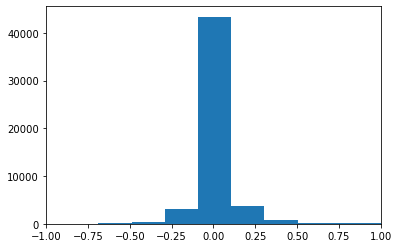

In [49]:
plt.hist(x=df['log_error'], bins = 50)
plt.xlim(-1,1);

### this looks good because it is close to 0, some over and under predict but the majority is close to 0


In [50]:
col = df.columns.to_list()
num_missing = df[col].isna().sum()
num_missing
df.shape[0]

52319

def null_counter(df):
    
    new_columns = ['name', 'num_rows_missing', 'pct_rows_missing']
    
    new_df = pd.DataFrame(columns=new_columns)
    
    for col in list(df.columns):
        num_missing = df[col].isna().sum()
        pct_missing = num_missing / df.shape[0]
        
        add_df = pd.DataFrame([{'name': col, 'num_rows_missing': num_missing,
                               'pct_rows_missing': pct_missing}])
        
        new_df = pd.concat([new_df, add_df], axis=0)
        
    new_df.set_index('name', inplace=True)
    
    return new_df

In [92]:
def null_counter(df):
    
    # name of dataframe names
    new_columns = ['name', 'num_rows_missing', 'pct_rows_missing']
    
    # create data frame
    new_df = pd.DataFrame(columns = new_columns)
   
    # for loop to calculate missing /percent by columns
    for col in list(df.columns):
        num_missing = df[col].isna().sum()
        pct_missing = num_missing / df.shape[0]
        
        # create data frame
        add_df = pd.DataFrame([{'name': col,
                               'num_rows_missing': num_missing,
                               'pct_rows_missing': pct_missing}])
       
        # concat and index by row by seting axis to 0   
        new_df = pd.concat([new_df, add_df], axis = 0)
        
    # sets the index name
    new_df.set_index('name', inplace = True)
    
    return new_df

In [93]:
null_counter(df)

,num_rows_missing,pct_rows_missing
name,,
id,0,0.000
parcelid,0,0.000
airconditioningtypeid,38704,0.740
architecturalstyletypeid,52249,0.999
basementsqft,52272,0.999
...,...,...
bulding_class,52319,1.000
heat_systems,18470,0.353
land_use,0,0.000


# Prepare

### 1.
Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer.

In [53]:
#Maybe there are some houses with no square footage?
df[df['calculatedfinishedsquarefeet'] == 0]

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,log_error,transaction_date,aircondition,architectural_style,bulding_class,heat_systems,land_use,story,construction_type


In [54]:
#What about nonexistent lots?
df[df['lotsizesquarefeet'] == 0]

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,log_error,transaction_date,aircondition,architectural_style,bulding_class,heat_systems,land_use,story,construction_type


In [55]:
#Maybe ones that have no bedrooms?
df[df['bedroomcnt'] == 0]

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,log_error,transaction_date,aircondition,architectural_style,bulding_class,heat_systems,land_use,story,construction_type
124,2546776,14190895,NaN,NaN,NaN,0.000,0.000,None,NaN,NaN,...,"60,590,218,121,000.000",-0.001,2017-01-03,None,None,None,None,Single Family Residential,None,None
590,2062723,11662937,NaN,NaN,NaN,5.000,0.000,None,10.000,5.000,...,"60,372,627,062,014.000",0.015,2017-01-05,None,None,None,None,Single Family Residential,None,None
2602,496818,11696784,NaN,NaN,NaN,0.000,0.000,None,NaN,NaN,...,"60,372,346,004,015.000",-0.125,2017-06-16,None,None,None,Floor/Wall,Single Family Residential,None,None
2683,1602501,12227894,NaN,NaN,NaN,0.000,0.000,None,4.000,NaN,...,"60,372,406,003,006.000",-0.025,2017-01-19,None,None,None,None,Single Family Residential,None,None
2887,856504,12146026,NaN,NaN,NaN,0.000,0.000,None,NaN,NaN,...,"60,374,308,032,008.000",-0.661,2017-01-20,None,None,None,None,Single Family Residential,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51689,1341842,11784034,1.000,NaN,NaN,1.000,0.000,None,NaN,1.000,...,"60,372,073,012,019.000",0.025,2017-09-14,Central,None,None,Central,Single Family Residential,None,None
52041,1759759,12399434,NaN,NaN,NaN,0.000,0.000,None,6.000,NaN,...,"60,375,505,001,000.000",0.510,2017-09-18,None,None,None,Central,Single Family Residential,None,None
52053,2004419,12000984,NaN,NaN,NaN,1.000,0.000,None,8.000,1.000,...,"60,377,002,004,004.000",-0.555,2017-09-18,None,None,None,None,Single Family Residential,None,None
52266,342540,11784041,1.000,NaN,NaN,1.000,0.000,None,NaN,1.000,...,"60,372,073,012,019.000",0.010,2017-09-19,Central,None,None,Central,Single Family Residential,None,None


### 2.
Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).

* The input:

     * A dataframe
            
     * A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column. i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing).
            
     * A number between 0 and 1 that represents the proportion, for each row, of columns/variables with non-missing values required to keep the row. For example, if prop_required_row = .75, then you are requiring a row to have at least 75% of variables with a non-missing value (no more that 25% missing).

* The output:

     * The dataframe with the columns and rows dropped as indicated. Be sure to drop the columns prior to the rows in your function.
        
* hint:

    * Look up the dropna documentation.
    * You will want to compute a threshold from your input values (prop_required) and total number of rows or columns.

In [56]:
def null_dropper(df,prop_required_column,prop_requred_row):
    
    # this is a decimal = 1- decimal
    prop_null_column = 1-prop_required_column
    
    # for columns, check null percentage and drop if a certain proportion is null (set by definition)
    for col in list(df.columns):
        null_sum = df[col].isna().sum()
        null_pct = null_sum / df.shape[0]
        
        if null_pct > prop_null_column:
            df.drop(columns = col, inplace = True)
    
    # for rows, drop if a certain proportion is null. (set by definition)
    row_threshold = int(prop_requred_row * df.shape[1])
    
    df.dropna(axis = 0, thresh=row_threshold, inplace = True)
    
    return df
    
    

In [57]:
df.shape

(52319, 68)

In [58]:
clean_df = null_dropper(df, 0.75, 0.75)

In [59]:
clean_df.head()

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,log_error,transaction_date,land_use
0,1727539,14297519,3.500,4.000,3.500,"3,100.000","3,100.000","6,059.000",3.000,"33,634,931.000",...,"1,998.000","485,713.000","1,023,282.000","2,016.000","537,569.000","11,013.720","60,590,630,072,012.000",0.026,2017-01-01,Single Family Residential
1,1387261,17052889,1.000,2.000,1.000,"1,465.000","1,465.000","6,111.000",1.000,"34,449,266.000",...,"1,967.000","88,000.000","464,000.000","2,016.000","376,000.000","5,672.480","61,110,010,023,006.000",0.056,2017-01-01,Single Family Residential
2,11677,14186244,2.000,3.000,2.000,"1,243.000","1,243.000","6,059.000",2.000,"33,886,168.000",...,"1,962.000","85,289.000","564,778.000","2,016.000","479,489.000","6,488.300","60,590,218,022,012.000",0.005,2017-01-01,Single Family Residential
3,2288172,12177905,3.000,4.000,3.000,"2,376.000","2,376.000","6,037.000",3.000,"34,245,180.000",...,"1,970.000","108,918.000","145,143.000","2,016.000","36,225.000","1,777.510","60,373,001,001,006.000",-0.103,2017-01-01,Single Family Residential
4,781532,12095076,3.000,4.000,3.000,"2,962.000","2,962.000","6,037.000",3.000,"34,145,202.000",...,"1,950.000","276,684.000","773,303.000","2,016.000","496,619.000","9,516.260","60,374,608,001,014.000",-0.001,2017-01-01,Single Family Residential


In [60]:
#Check shape of resulting dataframe
clean_df.shape

(52317, 29)

In [61]:
# clean_df.to_csv('zillow.csv')

### 3.
Encapsulate your work inside of functions in a wrangle_zillow.py module.

# Mall Customers

Notebook

1. Acquire data from the customers table in the mall_customers database.
2. Summarize the data (include distributions and descriptive statistics).
3. Detect outliers using IQR.
4. Split data into train, validate, and test.
5. Encode categorical columns using a one hot encoder (pd.get_dummies).
6. Handles missing values.
7. Scaling

Encapsulate your work in a wrangle_mall.py python module.

In [62]:
# 1.

mall_query = '''
SELECT *
FROM customers
'''

In [63]:
mall_database = 'mall_customer'
mall_df = pd.read_sql(mall_query, env.get_db_url('mall_customers'))

In [64]:
mall_df

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [79]:
## 2.
mall_df.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,200.000,100.500,57.879,1.000,50.750,100.500,150.250,200.000
age,200.000,38.850,13.969,18.000,28.750,36.000,49.000,70.000
annual_income,200.000,60.560,26.265,15.000,41.500,61.500,78.000,137.000
spending_score,200.000,50.200,25.824,1.000,34.750,50.000,73.000,99.000


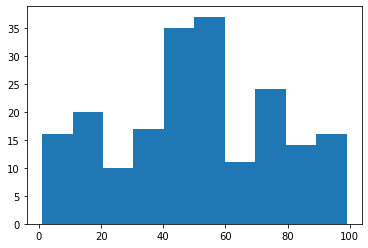

In [66]:
#Visualize distribution of target variable
plt.hist(mall_df['spending_score']);

In [67]:
mall_df.isna().sum()

customer_id       0
gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

In [68]:
## 3.
mall_df['age'].quantile([0.25, 0.75])

0.250   28.750
0.750   49.000
Name: age, dtype: float64

In [69]:
age_q1, age_q3 = mall_df['age'].quantile([0.25,0.75 ])

In [70]:
age_iqr = age_q3 - age_q1
age_iqr

20.25

In [71]:
age_upper = age_q3 + (age_iqr * 1.5)
age_lower = age_q1 - (age_iqr * 1.5)

age_upper, age_lower

(79.375, -1.625)

In [72]:
#Check for outliers in the age column
mall_df[mall_df['age'] > age_upper]

,customer_id,gender,age,annual_income,spending_score


In [73]:
# 4.
#Split my data into three subsets
seed = 42

mall_train, test_val = train_test_split(mall_df, train_size=0.7,
                                   random_state=seed)

mall_test, mall_val = train_test_split(test_val, train_size=0.5,
                                       random_state=seed)

mall_train.shape, mall_val.shape, mall_test.shape

((140, 5), (30, 5), (30, 5))

In [74]:
# 5.
#Check get_dummies works as expected on my training data
pd.get_dummies(mall_train)

,customer_id,age,annual_income,spending_score,gender_Female,gender_Male
169,170,32,87,63,0,1
97,98,27,60,50,1,0
31,32,21,30,73,1,0
12,13,58,20,15,1,0
35,36,21,33,81,1,0
...,...,...,...,...,...,...
106,107,66,63,50,1,0
14,15,37,20,13,0,1
92,93,48,60,49,0,1
179,180,35,93,90,0,1


In [75]:
#Create the dataframe with dummies for gender and drop redundant column
mall_train = pd.get_dummies(mall_train)

mall_train.drop(columns=['gender_Male'], inplace=True)

mall_train.head()

,customer_id,age,annual_income,spending_score,gender_Female
169,170,32,87,63,0
97,98,27,60,50,1
31,32,21,30,73,1
12,13,58,20,15,1
35,36,21,33,81,1


In [76]:
# 6.
#Check for missing values
mall_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 169 to 102
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   customer_id     140 non-null    int64
 1   age             140 non-null    int64
 2   annual_income   140 non-null    int64
 3   spending_score  140 non-null    int64
 4   gender_Female   140 non-null    uint8
dtypes: int64(4), uint8(1)
memory usage: 5.6 KB


In [77]:
mall_train.isnull().sum()

customer_id       0
age               0
annual_income     0
spending_score    0
gender_Female     0
dtype: int64

In [78]:
# 7.

#Initialize the scaler and fit/transform a couple columns in my training data
mms = MinMaxScaler()

mall_train[['age', 'annual_income']] = mms.fit_transform(mall_train[['age',
                                                                     'annual_income']])

mall_train.head()

,customer_id,age,annual_income,spending_score,gender_Female
169,170,0.269,0.590,63,0
97,98,0.173,0.369,50,1
31,32,0.058,0.123,73,1
12,13,0.769,0.041,15,1
35,36,0.058,0.148,81,1
